In [1]:
import os
import fnmatch


def filecount(dir_path):
    co= len(fnmatch.filter(os.listdir(dir_path), '*.*'))
    print(co)
    return co

dir1=r'C:\Users\hp\ImgClass_Fashion\image-classification-pants\train'
count_train=filecount(dir1)

dir2=r'C:\Users\hp\ImgClass_Fashion\image-classification-pants\test'
count_test=filecount(dir2)

18391
5751


In [2]:
import pandas as pd
data=pd.read_csv(r'C:\Users\hp\ImgClass_Fashion\image-classification-pants\train.csv')

data.label =data.label.astype('int64')
f=data['label'].value_counts()

print(f)
print(type(f))

1    5384
2    4084
3    2008
4    1972
6    1925
5    1616
0    1402
Name: label, dtype: int64
<class 'pandas.core.series.Series'>


In [3]:
y=data.iloc[:,-1].values

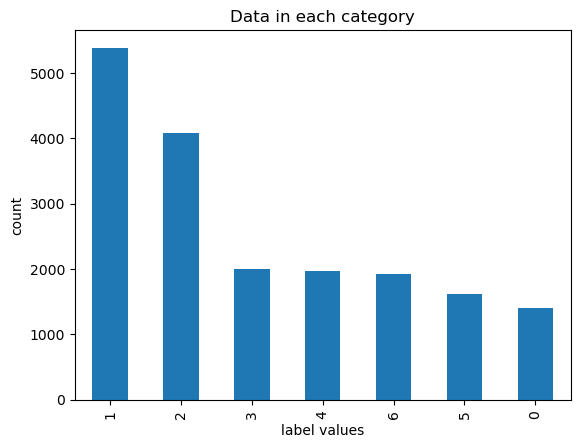

In [4]:
import matplotlib.pyplot as plt
data['label'].value_counts().plot(kind='bar')
plt.title('Data in each category')
plt.xlabel('label values')
plt.ylabel('count')
plt.show()

In [5]:
#y augmentation
import numpy as np

y_aug = np.empty((0,), dtype=int)
c0,c2,c3,c4,c5,c6=0,0,0,0,0,0
ind= np.empty((0,), dtype=int)

for i in range(len(y)):
    if (y[i] == 0 and c0 <247):
        y_aug = np.append(y_aug, y[i])
        y_aug = np.append(y_aug, np.zeros(16, dtype=int))
        c0+=1
        ind=np.append(ind,i)
    elif (y[i] == 2 and c2 <80):
        y_aug = np.append(y_aug, y[i])
        y_aug = np.append(y_aug, np.full(16, 2, dtype=int))
        c2+=1
        ind=np.append(ind,i)
    elif (y[i] == 3 and c3 <211):
        y_aug = np.append(y_aug, y[i])
        y_aug = np.append(y_aug, np.full(16, 3, dtype=int))
        c3+=1
        ind=np.append(ind,i)
    elif (y[i] == 4 and c4 <212):
        y_aug = np.append(y_aug, y[i])
        y_aug = np.append(y_aug, np.full(16, 4, dtype=int))
        c4+=1
        ind=np.append(ind,i)
    elif (y[i] == 5 and c5 < 234):
        y_aug = np.append(y_aug, y[i])
        y_aug = np.append(y_aug, np.full(16, 5, dtype=int))
        c5+=1
        ind=np.append(ind,i)
    elif (y[i] == 6 and c6 < 215):
        y_aug = np.append(y_aug, y[i])
        y_aug = np.append(y_aug, np.full(16, 6, dtype=int))
        c6+=1
        ind=np.append(ind,i)
    else:
        y_aug = np.append(y_aug, y[i])


print(len(y_aug))

37575


In [6]:
unique_values, counts = np.unique(y_aug, return_counts=True)

print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: [0 1 2 3 4 5 6]
Counts: [5354 5384 5364 5384 5364 5360 5365]


In [7]:
import cv2

def groupdata(path):
    x=[]
    for img in os.listdir(path):
        image_path=path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(32,32))
        x.append(img_arr)
    print(len(x))
    return x

x=groupdata(dir1)
x_unseen=groupdata(dir2)

18391
5751


In [8]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [9]:
x_aug=[]
for i in range(len(x)):
    if i in ind:
        
        img = x[i]
        x_aug.append(x[i])
        img = img.reshape((1,) + img.shape)
        aug_iter = datagen.flow(img, batch_size=1)
        for j in range(16):
            aug_img = next(aug_iter)[0].astype(np.uint8)
            x_aug.append(aug_img)
    else:
        x_aug.append(x[i])
x_aug=np.array(x_aug)

In [10]:
print(x_aug.shape)


(37575, 32, 32, 3)


In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_aug,y_aug,test_size=0.333, random_state=42)

In [12]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

25062
12513
25062
12513


In [13]:
unique_values, counts = np.unique(y_train, return_counts=True)

print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: [0 1 2 3 4 5 6]
Counts: [3540 3610 3601 3598 3512 3595 3606]


In [14]:
import numpy as np

x_train=np.array(x_train)
x_test=np.array(x_test)
x_unseen=np.array(x_unseen)

x_train=(x_train.astype('float32'))/255.0
x_test=(x_test.astype('float32'))/255.0
x_unseen=(x_unseen.astype('float32'))/255.0

In [15]:
from tensorflow import keras
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [16]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(25062, 32, 32, 3)
(12513, 32, 32, 3)
(25062, 7)
(12513, 7)


In [54]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), kernel_initializer='he_uniform',input_shape=x_train.shape[1:], padding='same'))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv2D(64, 3, activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.4))
    
model.add(keras.layers.Flatten())
#model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(128, activation='relu',kernel_initializer='he_uniform'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
import numpy
seed=21
numpy.random.seed(seed)
h1= model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=32)

Epoch 1/30
784/784 [==============================] - 90s 113ms/step - loss: 1.9108 - accuracy: 0.2612 - val_loss: 1.6150 - val_accuracy: 0.3611
Epoch 2/30
784/784 [==============================] - 90s 114ms/step - loss: 1.5869 - accuracy: 0.3753 - val_loss: 1.5123 - val_accuracy: 0.4046
Epoch 3/30
784/784 [==============================] - 90s 115ms/step - loss: 1.4819 - accuracy: 0.4228 - val_loss: 1.3856 - val_accuracy: 0.4491
Epoch 4/30
784/784 [==============================] - 91s 116ms/step - loss: 1.4167 - accuracy: 0.4505 - val_loss: 1.2965 - val_accuracy: 0.4985
Epoch 5/30
784/784 [==============================] - 89s 114ms/step - loss: 1.3620 - accuracy: 0.4733 - val_loss: 1.2566 - val_accuracy: 0.5099
Epoch 6/30
784/784 [==============================] - 89s 113ms/step - loss: 1.3170 - accuracy: 0.4940 - val_loss: 1.2148 - val_accuracy: 0.5318
Epoch 7/30
784/784 [==============================] - 89s 113ms/step - loss: 1.2757 - accuracy: 0.5144 - val_loss: 1.2418 - val_ac

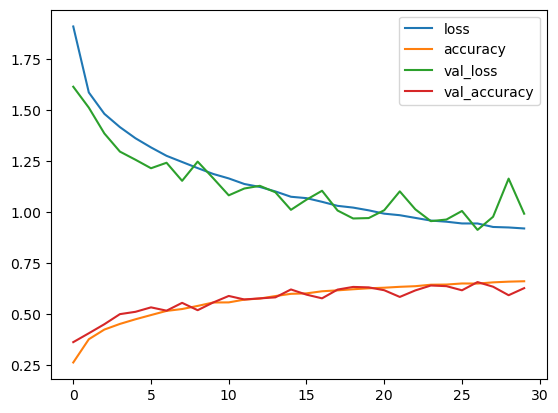

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(h1.history).plot()
plt.show()

In [26]:
prob= model.predict(x_unseen)

180/180 [==============================] - 4s 20ms/step


In [37]:
pre_label = np.argmax(prob,axis=1)


In [39]:
import os
import glob

img_dir = r"C:\Users\hp\ImgClass_Fashion\image-classification-pants\test"  
extensions = ['*.jpg', '*.jpeg', '*.png']  

image_files = []
for extension in extensions:
    image_files.extend(glob.glob(os.path.join(img_dir, extension)))

image_files = [os.path.basename(f) for f in image_files]

print(image_files[:5])

['Image_test_00001.jpg', 'Image_test_00002.jpg', 'Image_test_00003.jpg', 'Image_test_00004.jpg', 'Image_test_00005.jpg']


In [42]:
import csv
with open('TestImage_labels.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['file_name', 'label'])
    for i in range(len(image_files)):
        writer.writerow([image_files[i], pre_label[i]])

In [55]:
import numpy
seed=21
numpy.random.seed(seed)
h1= model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=25, batch_size=32)

Epoch 1/25
784/784 [==============================] - 101s 117ms/step - loss: 1.9250 - accuracy: 0.2623 - val_loss: 1.6644 - val_accuracy: 0.3189
Epoch 2/25
784/784 [==============================] - 90s 115ms/step - loss: 1.5928 - accuracy: 0.3642 - val_loss: 1.4671 - val_accuracy: 0.4264
Epoch 3/25
784/784 [==============================] - 102s 130ms/step - loss: 1.4959 - accuracy: 0.4137 - val_loss: 1.4035 - val_accuracy: 0.4491
Epoch 4/25
784/784 [==============================] - 95s 122ms/step - loss: 1.4286 - accuracy: 0.4429 - val_loss: 1.3054 - val_accuracy: 0.4981
Epoch 5/25
784/784 [==============================] - 91s 116ms/step - loss: 1.3693 - accuracy: 0.4710 - val_loss: 1.2650 - val_accuracy: 0.5040
Epoch 6/25
784/784 [==============================] - 94s 120ms/step - loss: 1.3230 - accuracy: 0.4906 - val_loss: 1.2115 - val_accuracy: 0.5334
Epoch 7/25
784/784 [==============================] - 107s 137ms/step - loss: 1.2831 - accuracy: 0.5114 - val_loss: 1.2266 - val

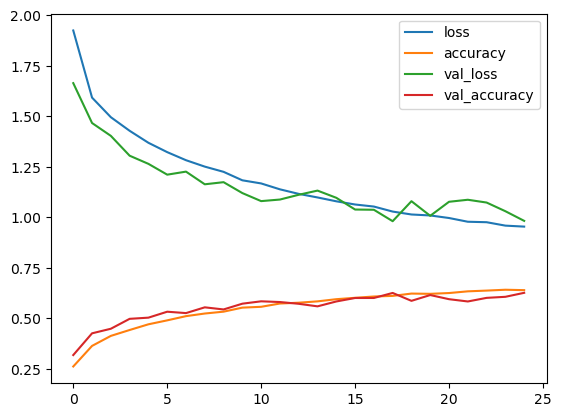

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(h1.history).plot()
plt.show()

In [57]:
prob= model.predict(x_unseen)

180/180 [==============================] - 4s 21ms/step


In [58]:
pre_label = np.argmax(prob,axis=1)

In [59]:
import os
import glob

img_dir = r"C:\Users\hp\ImgClass_Fashion\image-classification-pants\test"  
extensions = ['*.jpg', '*.jpeg', '*.png']  

image_files = []
for extension in extensions:
    image_files.extend(glob.glob(os.path.join(img_dir, extension)))

# Extract just the file names without the path
image_files = [os.path.basename(f) for f in image_files]

print(image_files[:5])

['Image_test_00001.jpg', 'Image_test_00002.jpg', 'Image_test_00003.jpg', 'Image_test_00004.jpg', 'Image_test_00005.jpg']


In [60]:
pre_label[:5]

array([2, 4, 2, 1, 2], dtype=int64)

In [61]:
import csv
with open('Results_Imagelabels.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['file_name', 'label'])
    for i in range(len(image_files)):
        writer.writerow([image_files[i], pre_label[i]])